In [1]:
# Import required packages
from openoa.utils import entr
from openoa.utils import plot
import pandas as pd
import matplotlib.pyplot as plt

# Get connection to ENTR warehouse
conn = entr.PySparkEntrConnection()

## Run AEP In Parallel across multiple wind plants using Spark

This notebook was run in the ENTR runtime.

View the wind plant table in the ENTR warehouse to see what plants are available for analysis.

In [2]:
conn.pandas_query("select * from dim_asset_wind_plant where plant_name='La Haute Borne'")

,plant_id,plant_name,latitude,longitude,plant_capacity,number_of_turbines,turbine_capacity
0,1,La Haute Borne,48.452000,5.588000,8.200000,4,2.050000


We are going to perform the OpenOA Monte Carlo AEP analysis on three of these wind plants. We can specify which wind plants to run the analysis on using a list of plant names. Then, we use the aep_spark_map function in the OpenOA entr toolkit to perform the analysis in Spark.

Metadata and some debugging information is printed out by this function.

In [3]:
%%time
plants = ["La Haute Borne"]
aep_results = entr.aep_spark_map(conn, plants)

{'La Haute Borne': {'latitude': 48.452, 'longitude': 5.588, 'capacity': 8.2, 'number_of_turbines': 4, 'turbine_capacity': 2.05, '_entr_plant_id': 1, 'reanalysis': {'era5': {'frequency': 'H', 'surface_pressure': 'WMETR.EnvPres', 'temperature': 'WMETR.EnvTmp', 'time': 'date_time', 'windspeed_u': 'WMETR.HorWdSpdU', 'windspeed_v': 'WMETR.HorWdSpdV', 'density': 'WMETR.AirDen'}, 'merra2': {'frequency': 'H', 'surface_pressure': 'WMETR.EnvPres', 'temperature': 'WMETR.EnvTmp', 'time': 'date_time', 'windspeed_u': 'WMETR.HorWdSpdU', 'windspeed_v': 'WMETR.HorWdSpdV', 'density': 'WMETR.AirDen'}}, 'curtail': {'frequency': '1M', 'availability': 'IAVL.DnWh', 'curtailment': 'IAVL.ExtPwrDnWh', 'time': 'date_time'}, 'meter': {'frequency': '10T', 'energy': 'MMTR.SupWh', 'time': 'date_time'}}}
Building the main query
Running the main query
CPU times: user 76.1 ms, sys: 33.7 ms, total: 110 ms
Wall time: 52.5 s


We can see it has taken the Spark engine just about 1 minute to run this computation in parallel. The aep_results is a list of plant names and their respective OpenOA Monte Carlo AEP results objects. This is the same object which is accessible through PlantAnalysis.results.

Let's use the OpenOA plotting toolkit to plot the results.

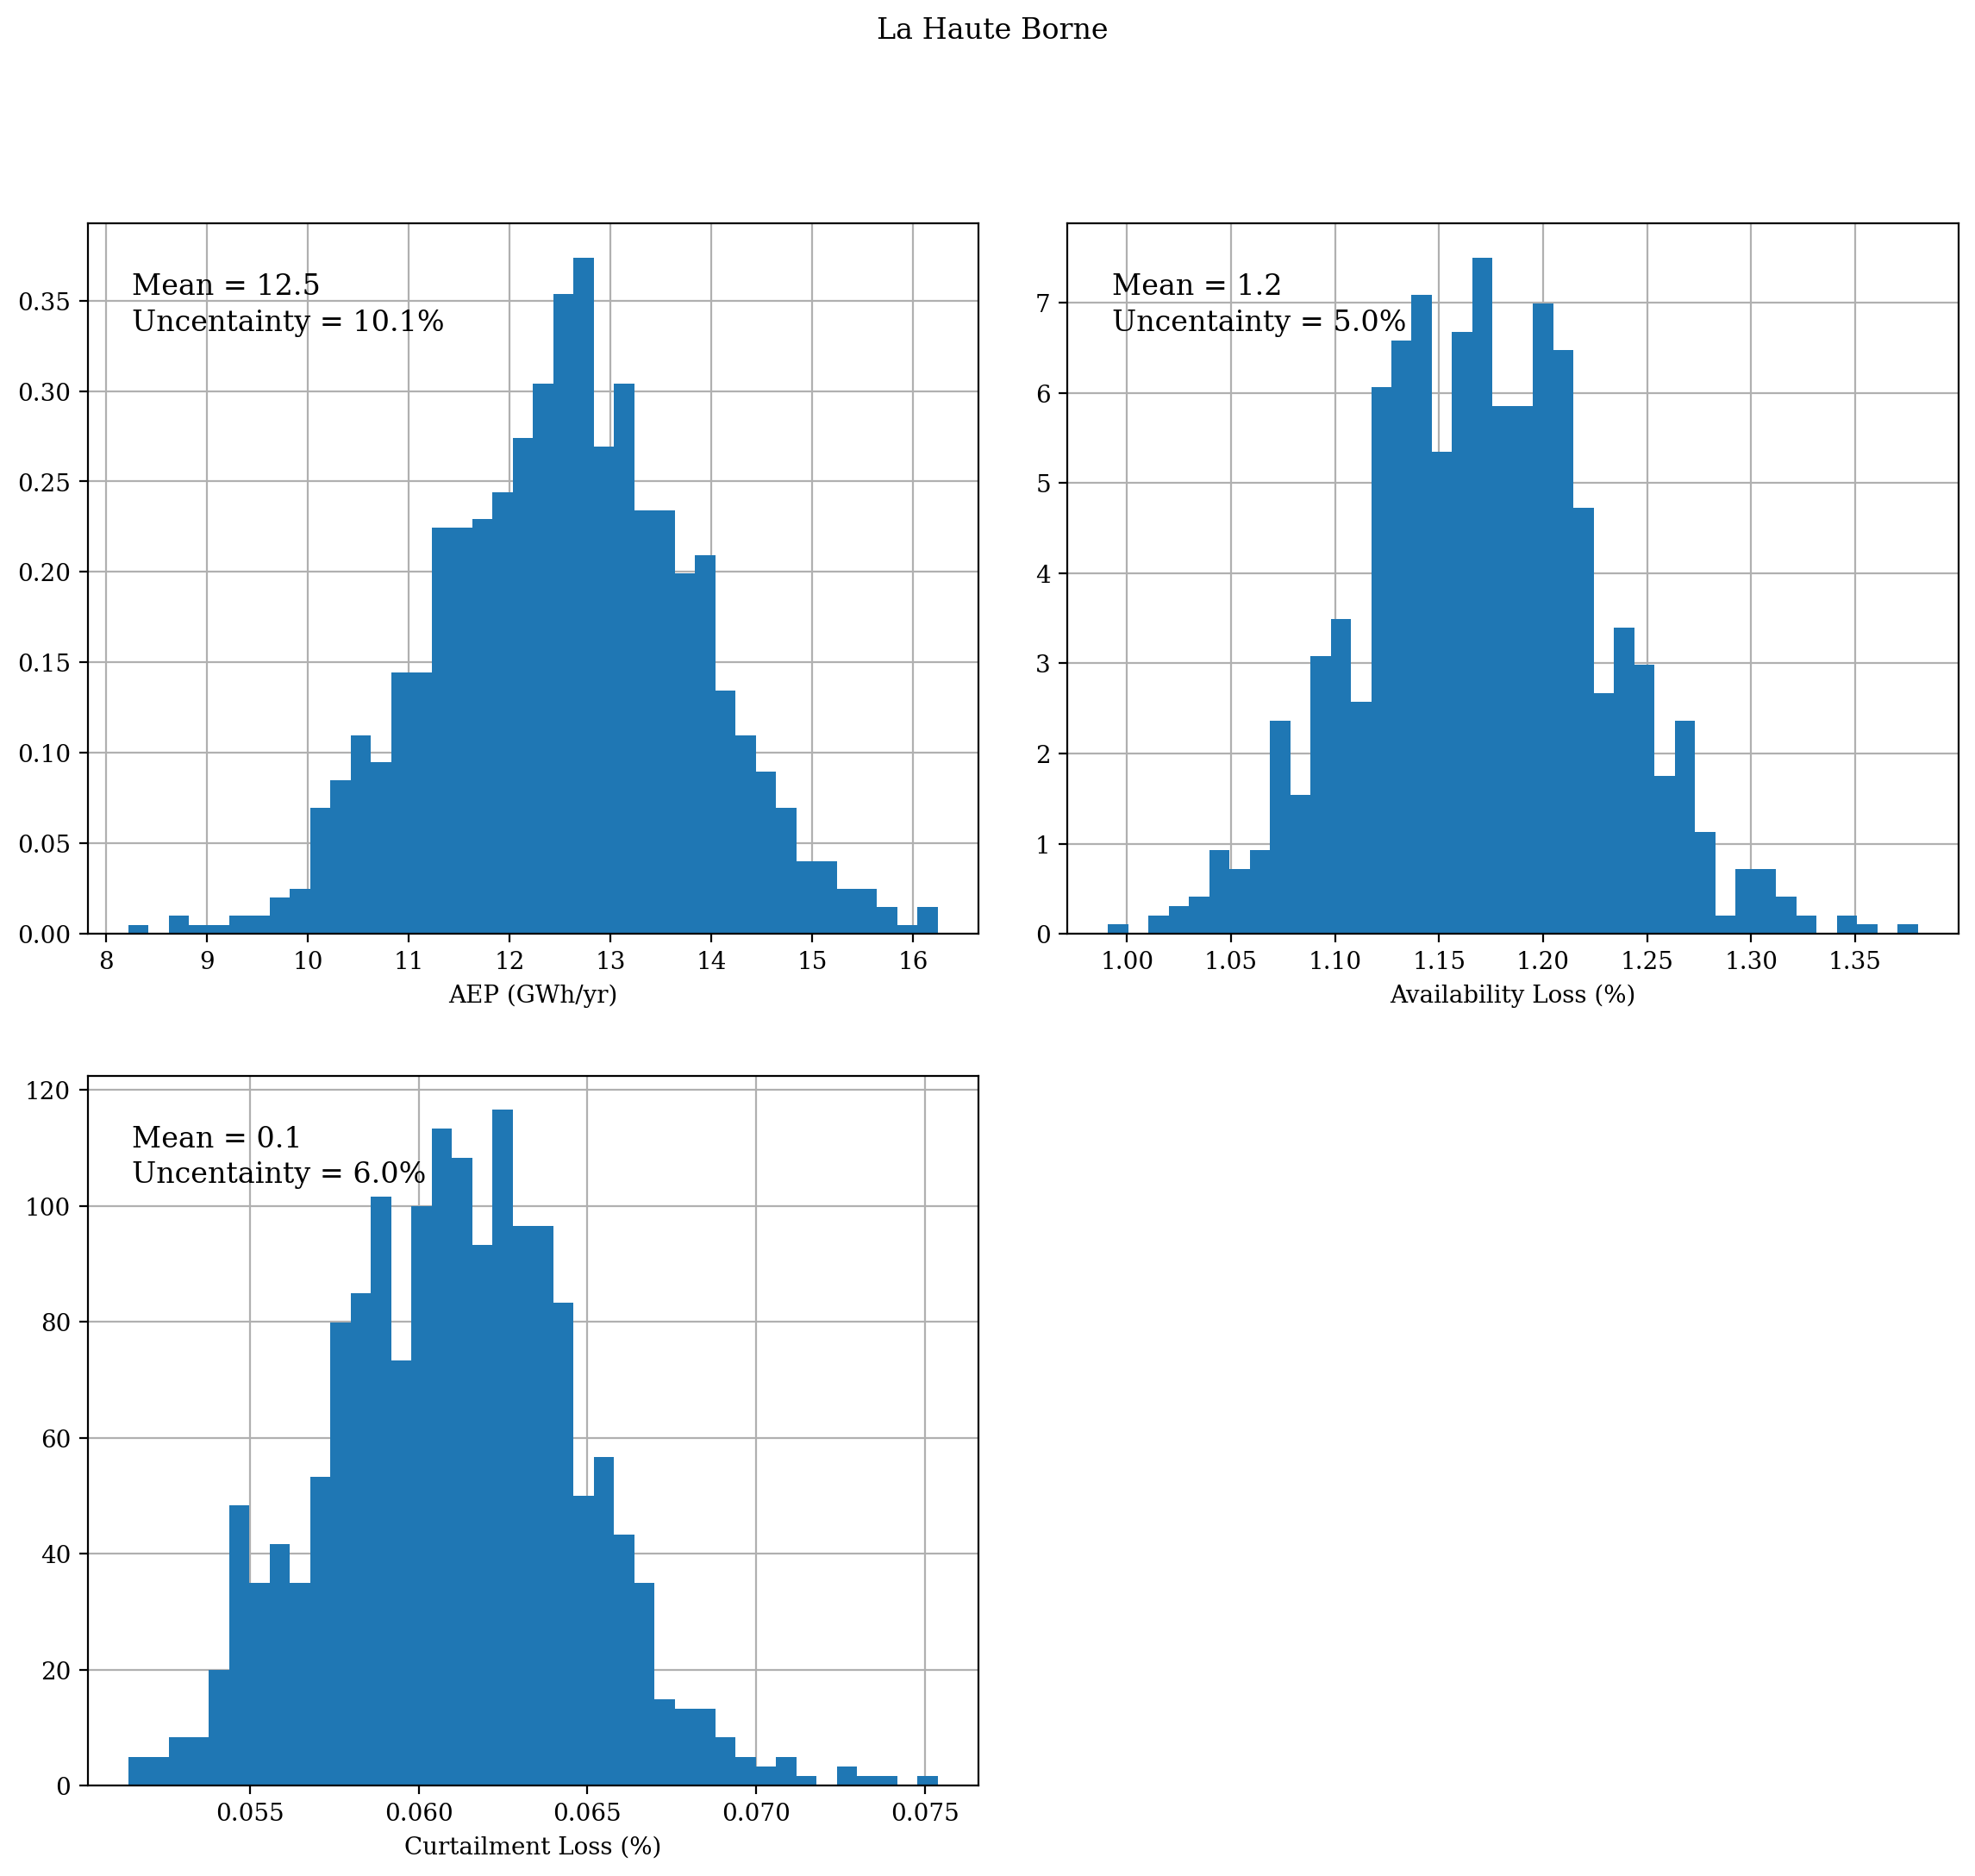

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 41784)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp

In [4]:
for plant_name, results in aep_results:
    plot_results = results.copy()
    plot_results[["avail_pct", "curt_pct"]] = plot_results[["avail_pct", "curt_pct"]] * 100
    plot.plot_distributions(
        data=plot_results,
        which=["aep_GWh", "avail_pct", "curt_pct"],
        xlabels=["AEP (GWh/yr)", "Availability Loss (%)", "Curtailment Loss (%)"],
        title=plant_name
    )